## Importing packages

Importing all needed packages for the full notebook. Only needs to be ran once. 

In [1]:
import sys
!{sys.executable} -m pip install rouge-score

In [2]:
import gzip as gz
import json
import sys as sklearn
import spacy as sp
import pandas as pd
import numpy as np
import re
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge import Rouge
import matplotlib.pyplot as plt

## Importing data

In [3]:
# Setting local file path
path = "newsroom-release/release/dev.jsonl.gz"

# Creating list entity to hold full set of loaded data
data = []

# Using gz to set path to zip file and iteritavly load each json line
with gz.open(path) as f:
    for ln in f:
        obj = json.loads(ln)
        data.append(obj)

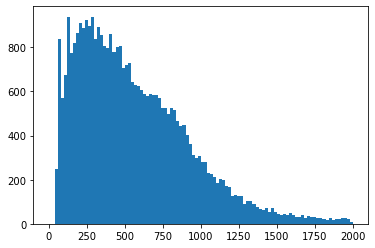

In [4]:
# Extracting appropriate data and transforming to pandas dataframe
df = pd.DataFrame(data)
df_extractive = df[df.density_bin == 'extractive']

# Filtering on rough estimate of lenght text
article_lengths = [len(text.split()) for text in df_extractive.text]
_ = plt.hist(article_lengths, bins = 100, range = (0, 2000))
length_check = [len > 250 for len in article_lengths]
df_extractive = df_extractive[length_check]

## Intermidiate Input Representation


### Sentence splitting

In [5]:
nlp = sp.load("en_core_web_sm", disable=["tagger", "parser", "ner", "textcat"])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [6]:
# SENTENCE SPLITTING FUNCTION
def sentence_splitting(doc):
    doc = nlp(doc['text'])
    sentences = [sent.string.strip() for sent in doc.sents]
    
    return sentences

### Sparse TF-ISF matrix representation

In [7]:
# PREPROCESS FUNCTION 
def preprocess(text):
    text = nlp(text)
    tokens = []
    for token in text:
        if token.is_stop == False and token.is_alpha == True:
            tokens.append(token.lemma_)
    
    return tokens

In [8]:
# TF-ISF MATRIX CREATION FUNCTION
def create_tfisf_matrix(sentences, preprocessor = preprocess):
    #Initializing ScikitLearn TF-IDF vectorizer and creating TF-IDF sparse matrix
    vectorizer = TfidfVectorizer(tokenizer = preprocessor)
    tfisf_matrix = vectorizer.fit_transform(sentences)
    
    # Saving list of all corpus tokens
    feature_names = vectorizer.get_feature_names()

    # Returning TF-IDF matrix
    return tfisf_matrix, feature_names

### Sentence scoring

In [22]:
# SENTENCE SCORING FUNCTION
def tfisf_sentence_scoring(tfisf_matrix, feature_names, sentences):
    sentence_scores = []
    tfisf_matrix =  pd.DataFrame.sparse.from_spmatrix(tfisf_matrix, columns=feature_names)
    tfisf_matrix_row_sum = tfisf_matrix.sum(axis = 1)

    for i, sentence in enumerate(sentences):
        sentence_scores.append((i, tfisf_matrix_row_sum[i]))#/len(sentence)))
    
    sentence_scores = pd.DataFrame(sentence_scores,columns=["sentence_index", "sentence_score"]).sort_values(by='sentence_score', ascending=False)
    
    return sentence_scores

### Extract summary sentences and merge

In [10]:
# SENTENCE EXTRACTION FUNCTION
def tfisf_sentence_extraction(sentences, sentence_scores, n):
    summary = []
    
    # Extracting indices of the n number of top scoring sentences
    # sort them in ascending order
    top_sentence_indices = np.sort(sentence_scores[0:n].sentence_index.values)

    # Extracting the original sentences and appending to summary list
    for index in top_sentence_indices:
        summary.append(sentences[index])
        
    # Joining summary sentences
    summary = ' '.join(summary)
    
    return summary

## Score summaries with ROUGE

In [11]:
# ROUGE SCORING FUNCTION
def rouge_blue_scoring(summaries, references):
    rouge_score = rouge.get_scores(summaries, references)
    return rouge_score

# Running the Experiment

In [23]:
corpus = df_extractive
corpus.reset_index(inplace = True)
summaries = []

for index, doc in corpus.iterrows():
    sentences = sentence_splitting(doc)
    tfisf_matrix, feature_names = create_tfisf_matrix(sentences = sentences)
    sentence_scores = tfisf_sentence_scoring(tfisf_matrix, feature_names, sentences)
    summary = tfisf_sentence_extraction(sentences, sentence_scores, 3)
    summaries.append(summary)

In [24]:
# ROUGE Scoring 
rouge = Rouge()
scores = rouge_blue_scoring(summaries, corpus.iloc[0:len(summaries)].summary.values.tolist())
scores_pd = pd.DataFrame(scores)

rouge1_f1_scores = []
rouge1_recall_scores = []
rouge1_precision_scores = []

rouge2_f1_scores = []
rouge2_recall_scores = []
rouge2_precision_scores = []

rougel_f1_scores = []
rougel_recall_scores = []
rougel_precision_scores = []

for i, score in scores_pd.iterrows():
    rouge1_f1_scores.append(score['rouge-1']['f'])
    rouge1_recall_scores.append(score['rouge-1']['r'])
    rouge1_precision_scores.append(score['rouge-1']['p'])
    
    rouge2_f1_scores.append(score['rouge-2']['f'])
    rouge2_recall_scores.append(score['rouge-2']['r'])
    rouge2_precision_scores.append(score['rouge-2']['p'])
    
    rougel_f1_scores.append(score['rouge-l']['f'])
    rougel_recall_scores.append(score['rouge-l']['r'])
    rougel_precision_scores.append(score['rouge-l']['p'])
    
rouge1_f1_average = sum(rouge1_f1_scores)/len(rouge1_f1_scores)
rouge1_recall_average = sum(rouge1_recall_scores)/len(rouge1_recall_scores)
rouge1_precision_average = sum(rouge1_precision_scores)/len(rouge1_precision_scores)

rouge2_f1_average = sum(rouge2_f1_scores)/len(rouge2_f1_scores)
rouge2_recall_average = sum(rouge2_recall_scores)/len(rouge2_recall_scores)
rouge2_precision_average = sum(rouge2_precision_scores)/len(rouge2_precision_scores)

rougel_f1_average = sum(rougel_f1_scores)/len(rougel_f1_scores)
rougel_recall_average = sum(rougel_recall_scores)/len(rougel_recall_scores)
rougel_precision_average = sum(rougel_precision_scores)/len(rougel_precision_scores)


res = {'r1': {'r': rouge1_recall_average, 'p': rouge1_precision_average, 'f1': rouge1_f1_average},
      'r2': {'r': rouge2_recall_average, 'p': rouge2_precision_average, 'f1': rouge2_f1_average},
      'rl': {'r': rougel_recall_average, 'p': rougel_precision_average, 'f1': rougel_f1_average}}

pd.DataFrame(res).to_csv('TFISF_res.csv')